# Intersubject correlation analysis

In [2]:
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML
#from templateflow.api import get
import subprocess
import pickle
from datetime import datetime
from time import time
import pdb

## Getting parcellations 

The atlas namings correspond to the original FSL’s acronyms for them 

* HOCPAL=Harvard-Oxford Cortical Probabilistic Atlas Lateralized 
- 48 regions for both sides total of 96
* HOSPA=Harvard-Oxford Subcortical Probabilistic Atlas
- 21 regions


In [2]:
def adillyofapickle(basepath,dic, name):
    datefmt='%m-%d-%Y_%I-%M-%S'
    st = datetime.fromtimestamp(time()).strftime(datefmt)
    if os.path.exists(os.path.join(basepath,'tmp')):
        print('already have tmp')
    else:
        os.makedirs(os.path.join(basepath,'tmp'))
    pickle.dump(dic, open(os.path.join(basepath,'tmp','%s_%s'%(name,st)), 'wb'), protocol=4)


In [3]:
def onetoughjar(p):
    list_of_files = glob.glob(p) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getmtime)
    with open(latest_file, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

In [67]:
datapath = '/projects/niblab/experiments/bromocriptine/data/fmriprep/'
altaspath = '/projects/niblab/parcellations/Harvard_Oxford'
outpath = '/projects/niblab/data/BRO/timeseries'

In [ ]:
subcort_dict = onetoughjar(os.path.join(altaspath,'tmp','subcortical*'))

In [ ]:
cort_dict = onetoughjar(os.path.join(altaspath,'tmp','cortical*'))

In [ ]:
subcort_dict.keys()

## Sample mask into functional space
I used fslmeants to get the timeseries per parcel (cortical and subcortical) the masks were first sampled into subject space from 1mm to 3mm.

## Making a dictonary with the labels for the ROIS

In [ ]:
#cort_labels = pd.read_csv(os.path.join(outpath,'atlas.csv'), header = None)

In [ ]:
#cort_dict = {}

# for index, row in cort_labels.iterrows():
#     ROW = row[0].split(' ')
#     name1 = ROW[5]
#     name2 = ROW[6]
#     if '%s_%s'%(name1, name2) in cort_dict.values():
#         cort_dict.update({int(ROW[1].split('=')[-1]):'%s_%s_%s'%(name1, name2, index)})
#     else:
#         cort_dict.update({int(ROW[1].split('=')[-1]):'%s_%s'%(name1, name2)})

In [ ]:
#adillyofapickle(altaspath,cort_dict, 'cortical')

In [ ]:
#subcort_labels = pd.read_csv(os.path.join(outpath,'atlas_sub.csv'), header = None, delimiter = ' ')

In [ ]:
# subcort_dict = {}
# for index, row in subcort_labels.iterrows():
#     name1 = row[15]
#     name2 = row[16]
#     name3 = row[17]
#     subcort_dict.update({int(row[3]):'%s_%s_%s'%(name1, name2, name3)})

In [ ]:
#adillyofapickle(altaspath,subcort_dict, 'subcortical')

In [ ]:
# data_dict = {}
# for x in glob.glob(os.path.join(outpath,'cortical_masks','*.txt')):
#     sub = x.split('/')[-1].split('_')[0]
#     ses = x.split('/')[-1].split('_')[1]
#     run = x.split('/')[-1].split('_')[2].split('.')[0]
#     print('%s %s %s'%(sub, ses, run))
#     df = pd.read_csv(x, header = None, delimiter = '  ')
#     df.rename(columns=cort_dict, inplace = True)
#     df2 = pd.read_csv(os.path.join(outpath,'subcortical_masks','%s_%s_%s.txt'%(sub,ses,run)), header = None, delimiter = '  ')
#     df2.rename(columns=subcort_dict, inplace = True)
#     DF = df.join(df2)
#     data_dict.update({'%s_%s_%s'%(sub,ses,run):DF})
    
    
    

In [ ]:
pd.concat([data_dict['sub-007_ses-1_run-1'], data_dict['sub-007_ses-1_run-2']], ignore_index=True)

In [ ]:
data_dict['sub-007_ses-1_run-1']

In [ ]:
# adillyofapickle(outpath,data_dict, 'timeseries_parc')

In [5]:
data_dict = onetoughjar(os.path.join(outpath,'tmp','timeseries*'))

In [ ]:
#data_dict['BRO']['run-1'].keys()

In [ ]:
# noNan_dict = {'BRO':{'run-1':{},'run-2':{}},'PLA':{'run-1':{},'run-2':{}}}

# for cond, data in data_dict.items():
#     for run, dat in data.items():
#         for sub, df in dat.items():
#             noNan_dict[cond][run].update({sub:df.dropna(axis=1)})
        

In [ ]:
# ROIS = pd.read_csv(os.path.join(altaspath,'tmp','ROIS.csv'))

In [6]:
path2beh = '/projects/niblab/data/BRO/behav/bro_behav.csv'
behav = pd.read_csv(path2beh)

In [7]:
behav2 = behav.set_index('participantID')

In [ ]:
# reorg_dict = {'BRO':{'run-1':{},'run-2':{}}, 
#               'PLA':{'run-1':{},'run-2':{}}
#              }
# for key, value in data_dict.items():
#     sub = key.split('_')[0]
#     ses = key.split('_')[1]
#     run = key.split('_')[2]
#     if behav2.loc[sub,'drug_v1'] == 'placebo':
#         if run == 'run-1':
#             reorg_dict['PLA']['run-1'].update({sub:value})
#         else:
#             reorg_dict['PLA']['run-2'].update({sub:value})
#     else:
#         if run == 'run-1':
#             reorg_dict['BRO']['run-1'].update({sub:value})
#         else:
#             reorg_dict['BRO']['run-2'].update({sub:value})

In [8]:
def get_subject_roi(data_dict, roi_num):
    sub_rois = {}
    for sub, value in data_dict.items():
        sub_rois[sub] = value[ROIS['0'].iloc[10]]
    return pd.DataFrame(sub_rois)


In [108]:
results_boot = {}
for x in range(0,96):
#     print(x)
    PLA = 'PLA_%s_bootstrap*'%x
    BRO = 'BRO_%s_bootstrap*'%x
    try:
        results_boot.update({
             x:{'PLA':onetoughjar(os.path.join('/projects/niblab/data/BRO/timeseries/tmp',PLA)),
                'BRO': onetoughjar(os.path.join('/projects/niblab/data/BRO/timeseries/tmp',BRO))}})
    except ValueError:
        print(x)


In [130]:
results_circle = {}
for x in range(0,96):
    PLA = 'PLA_%s_circle*'%x
    BRO = 'BRO_%s_circle*'%x
    try:
        results_circle.update({
         x:{'PLA':onetoughjar(os.path.join('/projects/niblab/data/BRO/timeseries/tmp',PLA)),
            'BRO': onetoughjar(os.path.join('/projects/niblab/data/BRO/timeseries/tmp',BRO))}})    
    except ValueError:
        print(x)

                              

In [131]:
results_circle.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

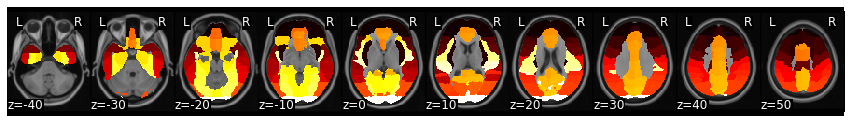

In [69]:
mask = Brain_Data(os.path.join(altaspath, 'tpl-MNI152NLin2009cAsym_res-01_atlas-HOCPAL_desc-th0_dseg.nii.gz'))
mask_x = expand_mask(mask)

mask.plot()

In [138]:
BRO_isc_r, BRO_isc_p = {}, {}
PLA_isc_r, PLA_isc_p = {}, {}

In [139]:
BROc_isc_r, BROc_isc_p = {}, {}
PLAc_isc_r, PLAc_isc_p = {}, {}

In [140]:
for roi, data in results_circle.items():
#     print(roi)
    BROc_isc_r[int(roi)] = data['BRO']['BRO']['%s_ROI'%roi]['stats']['isc']
    BROc_isc_p[int(roi)] = data['BRO']['BRO']['%s_ROI'%roi]['stats']['p']


In [141]:
for roi, data in results_boot.items():
#     print(roi)
    BRO_isc_r[int(roi)] = data['BRO']['BRO']['%s_ROI'%roi]['stats']['isc']
    BRO_isc_p[int(roi)] = data['BRO']['BRO']['%s_ROI'%roi]['stats']['p']
    
    
    
    

In [142]:
for roi, data in results_circle.items():
#     print(roi)
    PLAc_isc_r[int(roi)] = data['PLA']['PLA']['%s_ROI'%roi]['stats']['isc']
    PLAc_isc_p[int(roi)] = data['PLA']['PLA']['%s_ROI'%roi]['stats']['p']


In [143]:
for roi, data in results_boot.items():
#     print(roi)
    PLA_isc_r[int(roi)] = data['PLA']['PLA']['%s_ROI'%roi]['stats']['isc']
    PLA_isc_p[int(roi)] = data['PLA']['PLA']['%s_ROI'%roi]['stats']['p']


In [149]:
bro_isc_r_brain, bro_isc_p_brain = roi_to_brain(pd.Series(BRO_isc_r), mask_x), roi_to_brain(pd.Series(BRO_isc_p), mask_x)
broc_isc_r_brain, broc_isc_p_brain = roi_to_brain(pd.Series(BROc_isc_r), mask_x), roi_to_brain(pd.Series(BROc_isc_p), mask_x)


pla_isc_r_brain, pla_isc_p_brain = roi_to_brain(pd.Series(PLA_isc_r), mask_x), roi_to_brain(pd.Series(PLA_isc_p), mask_x)
plac_isc_r_brain, plac_isc_p_brain = roi_to_brain(pd.Series(PLAc_isc_r), mask_x), roi_to_brain(pd.Series(PLAc_isc_p), mask_x)



